In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC
%matplotlib inline

## A) Adatvizualizáció és klaszterezés

### A1) Adathalmaz bemutatása

Az adatbázisban egy nagykereskedelmi forgalmazó ügyfeleinek pénzegységben kifejezett költéseit láthatjuk termékkategóriánként. Emellett a Channel attribútum megmutatja, hogy az adott ügyfél a HoReCa (1), vagy kiskereskedelmi szektorba (2) tartozik. A Region pedig azt tartalmazza, hogy az ügyfél melyik régióhoz tartozik: Lisszabon (1), Porto (2), vagy portugália egyéb régiójába (3). Az ügyfelek nagyjából 2/3 része tartozik a HoReCa szektorhoz, a régióknál pedig több, mint 70%-uk az egyéb régiókba.

In [2]:
df = pd.read_csv('data_49.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
df.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
df['Channel'].value_counts(normalize=True)

Channel
1    0.677273
2    0.322727
Name: proportion, dtype: float64

In [6]:
df['Region'].value_counts(normalize=True)

Region
3    0.718182
1    0.175000
2    0.106818
Name: proportion, dtype: float64

In [7]:
pd.crosstab(df['Region'],df['Channel'])

Channel,1,2
Region,,
1,59,18
2,28,19
3,211,105


### A2) Előfeldolgozás

Az előfeldolgozás során láthatjuk, hogy szerencsére nincsenek hiányzó értékek az adattáblában, azonban kiugró értékeket több változó esetén is találhatunk, ezeket a későbbiekben szükséges lehet kezelni. Duplikált sorok sincsenek az adatok között.

In [8]:
df.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [9]:
columns=['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
columns_2=['Channel','Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

<Axes: >

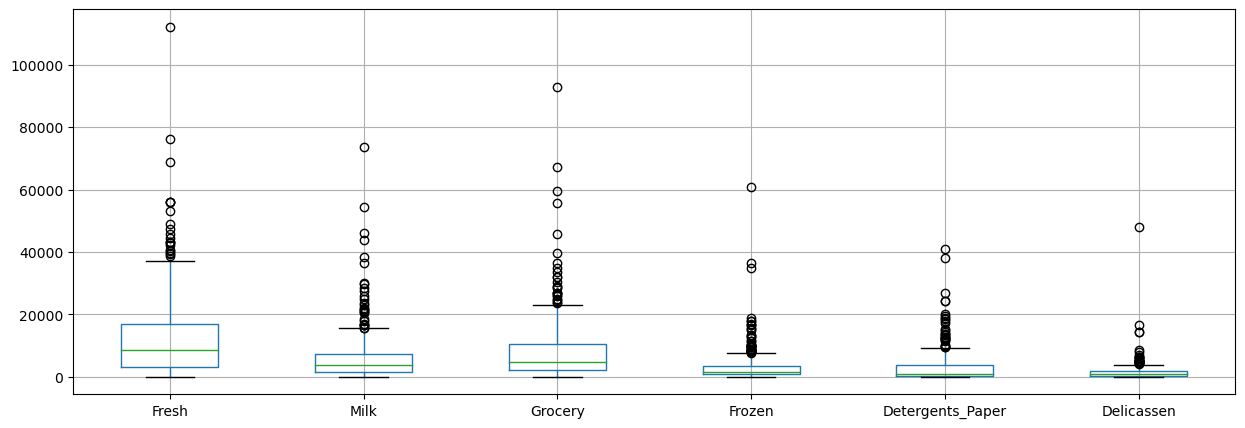

In [10]:
df[columns].boxplot(figsize=(15, 5))

In [11]:
df.sort_values(by=['Fresh'], ascending=False).head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
181,1,3,112151,29627,18148,16745,4948,8550
125,1,3,76237,3473,7102,16538,778,918
284,1,3,68951,4411,12609,8692,751,2406
39,1,3,56159,555,902,10002,212,2916
258,1,1,56083,4563,2124,6422,730,3321


In [12]:
duplicate= df[df.duplicated()]

In [13]:
duplicate.shape

(0, 8)

### A3) Vizualizáció

Az első vizualizáción láthatjuk az ügyfelek megoszlását a két szektor és a régiók között, valóban nagyobb arányban vannak az egyéb régióba tartozó ügyfelek. Ezután hőtérkép és korreláció segítségével összehasonlíthatjuk, hogy a változók páronként milyen kapcsolatban állnak egymással. Az élelmiszerek és a tisztítószer-papírtermékek között erős, pozitív irányú kapcsolatot láthatunk. A változók páronkénti kapcsolatát pontfelhőn is összehasonlíthatjuk. A tisztítószer-papírtermékeket violin plot segítségével ábrázoltam szektorok szerint, itt az figyelhető meg, hogy a kiskereskedelmi területen jelentős kiugró értékek találhatóak. Az utolsó vizualizáción az adattábla első öt sora látszik, a kategóriánkénti költésekkel együtt.

<Axes: xlabel='Channel', ylabel='count'>

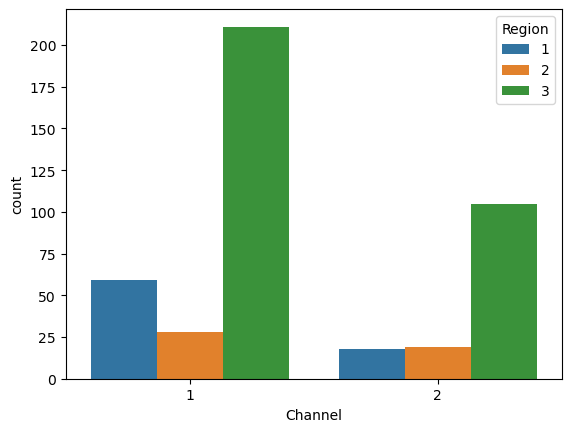

In [14]:
sns.countplot(data=df,x='Channel', hue='Region')
#1-HoReCa, 2-Retail

In [15]:
corr = df.loc[:,columns].corr()

<Axes: >

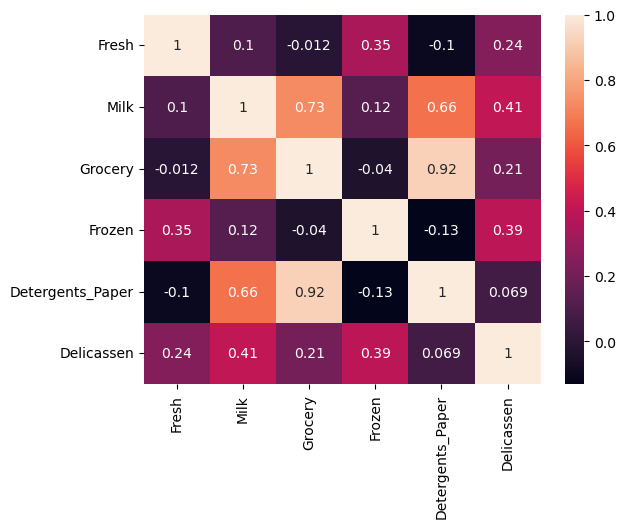

In [16]:
sns.heatmap(corr, annot=True)

E:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


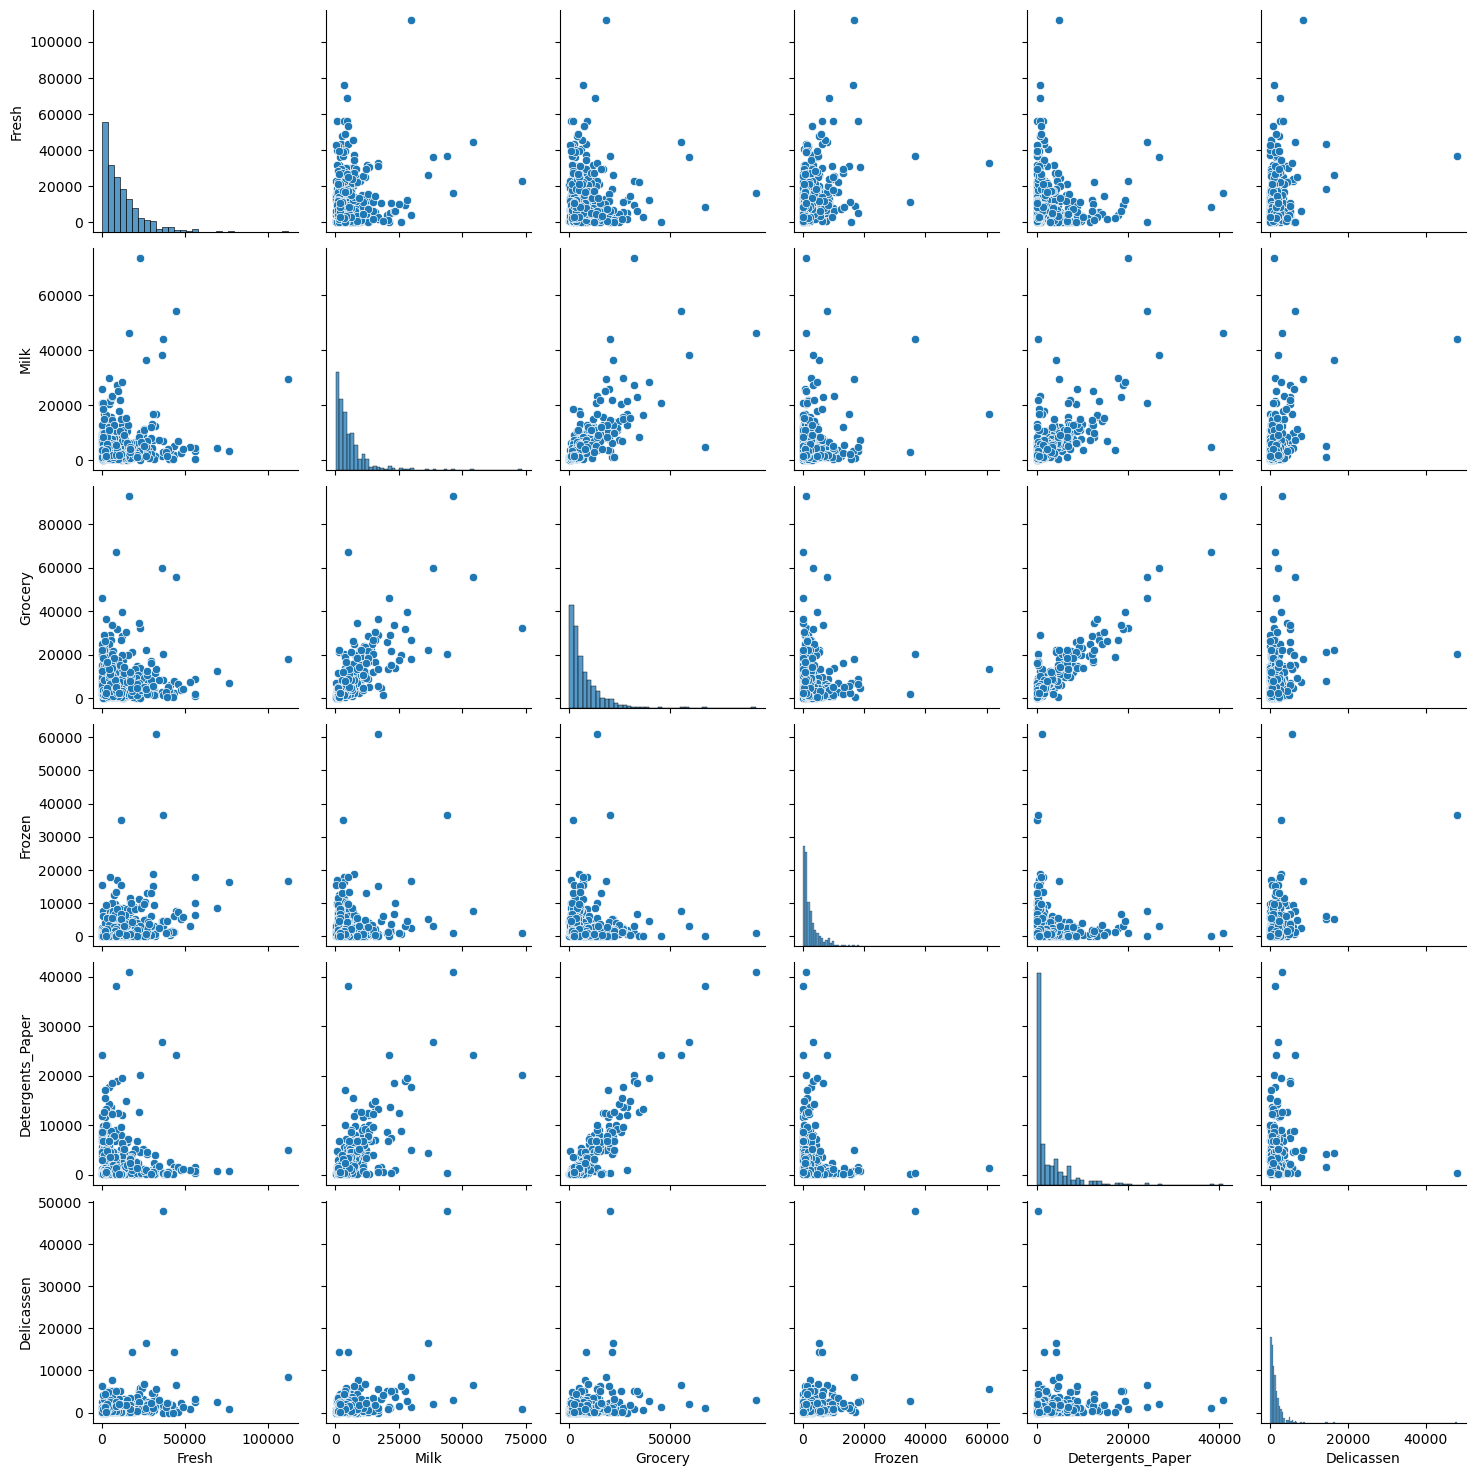

In [17]:
sns.pairplot(data=df[columns])

<Axes: xlabel='Channel', ylabel='Detergents_Paper'>

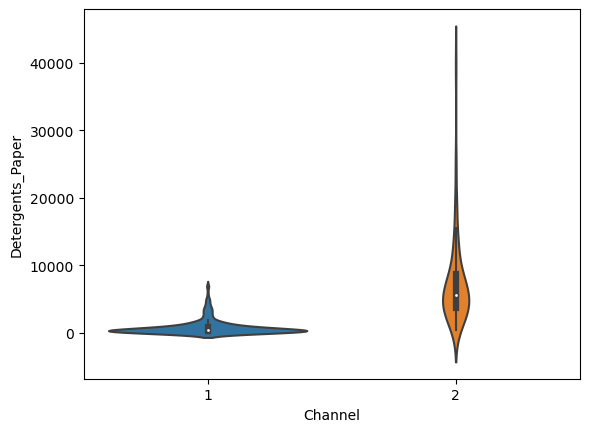

In [18]:
sns.violinplot(data=df,x='Channel',y='Detergents_Paper')

<Axes: >

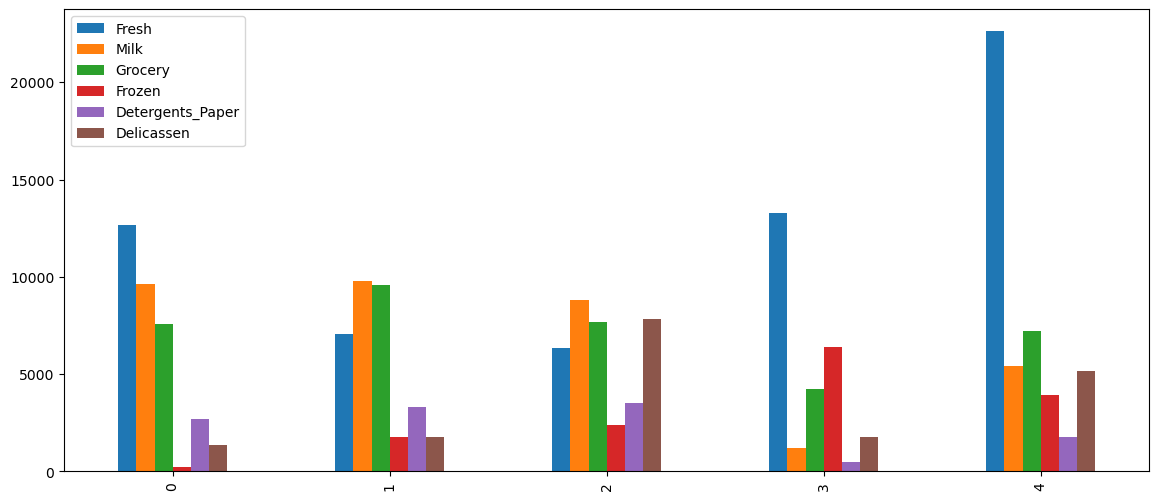

In [216]:
df[columns].head().plot(kind='bar', figsize=(14,6))

### A4) Klaszterezés

#### A4.1) K-közép

Az első klaszterezésre kiválasztott algoritmus a k-közép módszer, ami az adatpontokat k csoportba rendezi úgy, hogy a csoportokon belüli adatpontok közötti távolság minimális legyen. A Fresh és a Grocery változók értékei alapján klasztereztem, a csoportok számát az 'elbow method' segítségével határoztam meg. 

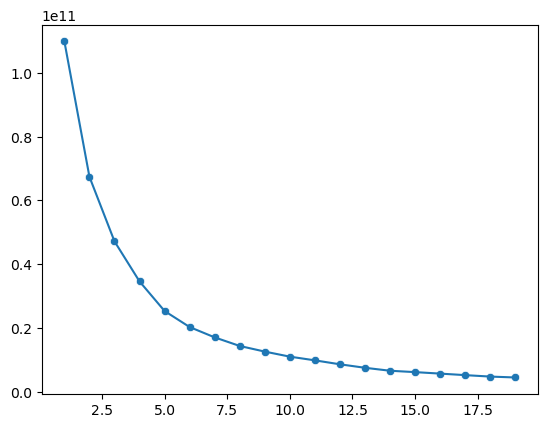

In [19]:
err = []
for i in range(1,20):
    kmeans = KMeans(n_clusters=i, n_init=10)
    kmeans.fit(df[['Fresh', 'Grocery']]);
    err.append([kmeans.n_clusters, kmeans.inertia_])

err = np.asarray(err)
sns.lineplot(x=err[:,0], y=err[:,1])
sns.scatterplot(x=err[:,0], y=err[:,1]);

In [189]:
kmeans = KMeans(n_clusters=4, n_init=10)
kmeans.fit(df[['Fresh', 'Grocery']]);

In [203]:
def plot_result(model, labels, centers, x, y):
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=x, y=y, hue=labels, palette="Set1", marker='.');
    sns.scatterplot(x=centers[:,0], y=centers[:,1], marker='X', s=100, c=['black']);

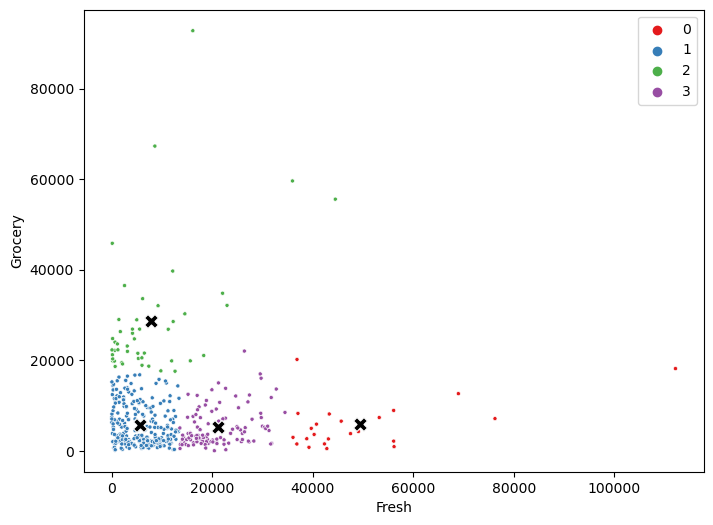

In [204]:
plot_result(kmeans, kmeans.labels_, kmeans.cluster_centers_, df['Fresh'], df['Grocery'])

#### A4.2) MeanShift

Egy másik klaszterező algoritmust, a MeanShift-et is kipróbáltam, amely az adatpontokat a sűrűségük maximuma felé tolva keresi meg a klaszterek középpontjait, itt nem szükséges előre megadni a klaszterek számát. Az ábrázolás után látszik a különbség a k-közép klaszterezéshez képest.

In [217]:
meanshift = MeanShift()
meanshift.fit(df[['Fresh', 'Grocery']])

MeanShift()

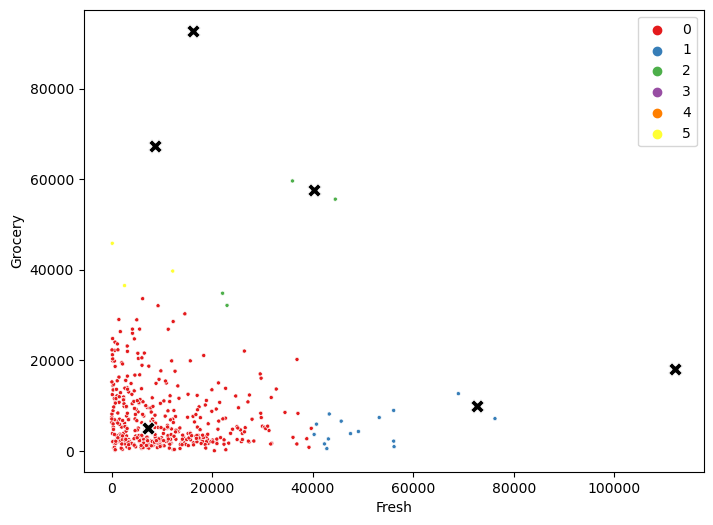

In [218]:
plot_result(meanshift, meanshift.labels_, meanshift.cluster_centers_, df['Fresh'], df['Grocery'])

## B) Lineáris regresszió

### B1) Attribútumok kiválasztása, regressziós feladat megfogalmazása

A lineáris regresszió egy statisztikai módszer, amely az adatok közötti kapcsolatot egy egyenes vonallal modellezi, előre jelezve az egyik változó értékét egy másik változó alapján. Az első modellben a Grocery (függő változó) értékét szeretném előrejelezni a Detergents_Paper (független változó) értékei alapján.

<Axes: xlabel='Detergents_Paper', ylabel='Grocery'>

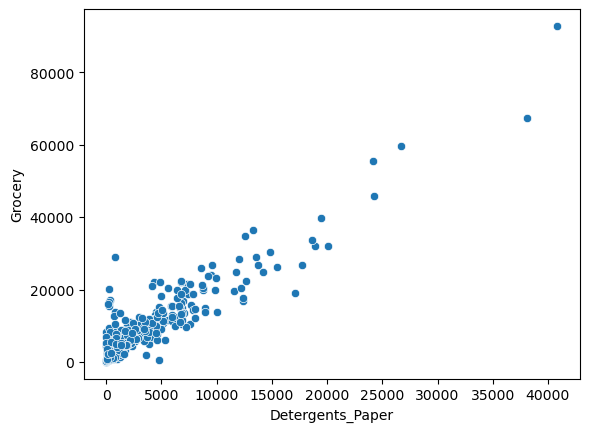

In [219]:
sns.scatterplot(x=df['Detergents_Paper'],y=df['Grocery'])

In [220]:
df.head(3)

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844


In [221]:
x = df[['Detergents_Paper']].to_numpy()
x[:3]

array([[2674],
       [3293],
       [3516]], dtype=int64)

In [222]:
y = df[['Grocery']].to_numpy()
y[:3]

array([[7561],
       [9568],
       [7684]], dtype=int64)

#### B2.1) Lineáris regresszió alkalmazása (1)

A modellben a theta0 az egyenes metszéspontja az y tengellyel, ez az a pont, ahol a független változó értéke nulla. A theta1 pedig az egyenes meredeksége, ami megmutatja, hogy a Grocery értéke hogyan változik a Detergents_Paper értékének egységnyi változásával. A reg.score() a modell teljesítményét értékeli, a statisztikában is használt R² mutató segítségével. Ennek az értéke 0 és 1 között lehet, minél közelebbi értéket kapunk az egyhez, a modell annál jobban magyarázza a független változót. A reg.predeict()-el egy tetszőleges Detergents_Paper értéket megadva előrejelezhetjük a Grocery értékét a modellünk segítségével.

In [223]:
reg = LinearRegression()
reg.fit(x,y)

LinearRegression()

In [224]:
theta0 = reg.intercept_
theta1 = reg.coef_[0]

In [225]:
theta0

array([2640.77279171])

In [226]:
theta1

array([1.84296965])

In [233]:
h = theta0 + theta1 * df['Detergents_Paper']

<Axes: >

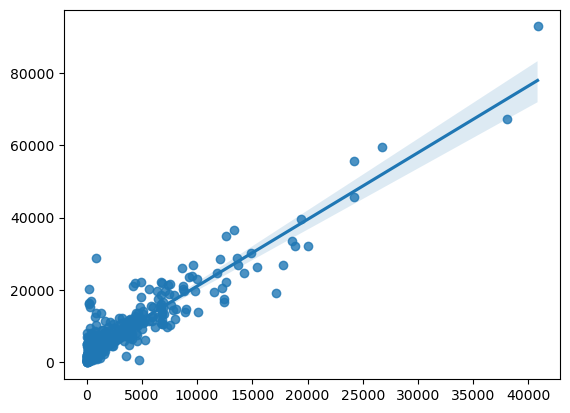

In [231]:
sns.regplot(x=x,y=y)

In [229]:
reg.score(x,y)

0.8549604071834576

In [230]:
reg.predict([[4200]])

array([[10381.24532206]])

#### B2.2) Lineáris regresszió alkalmazása (2)

A következő lineáris regresszióban az előző modellt annyival egészítettem ki, hogy itt független változóként még a Milk értékeit is felvettem,ezáltal egy magasabb R² értéket kaptunk.

In [234]:
x = df[['Detergents_Paper','Milk']].to_numpy()
y = df['Grocery'].to_numpy()

In [235]:
reg2 = LinearRegression()
reg2.fit(x,y)

LinearRegression()

In [236]:
theta0 = reg2.intercept_
theta1 = reg2.coef_[0]
theta2 = reg2.coef_[1]

In [237]:
h = theta0 + theta1 * df['Detergents_Paper'] + theta2 * df['Milk']

In [238]:
reg2.score(x,y)

0.8790661474084633

In [239]:
reg2.predict([[4200,3500]])

array([9408.67871073])

## C) Logisztikus regresszió

### C1) Attribútumok kiválasztása, regressziós feladat megfogalmazása

A logisztikus regresszió egyik különbsége a lineárissal szemben, hogy itt a függő változónk nem folytonos, hanem kategorikus. Egy esemény bekövetkezésének a valószínűsége előre megjósolható egy valószínűségi érték segítségével, ami bármilyen nulla és egy közötti érték lehet. Pontfelhőn ábrázoltam a változók páronkénti kapcsolatát és a Channel (kereskedelmi szektorok) kategóriáit, a regressziós feladatban a Channel értékét próbálom meghatározni a Frozen és Detergents_Paper változók segítségével.

E:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


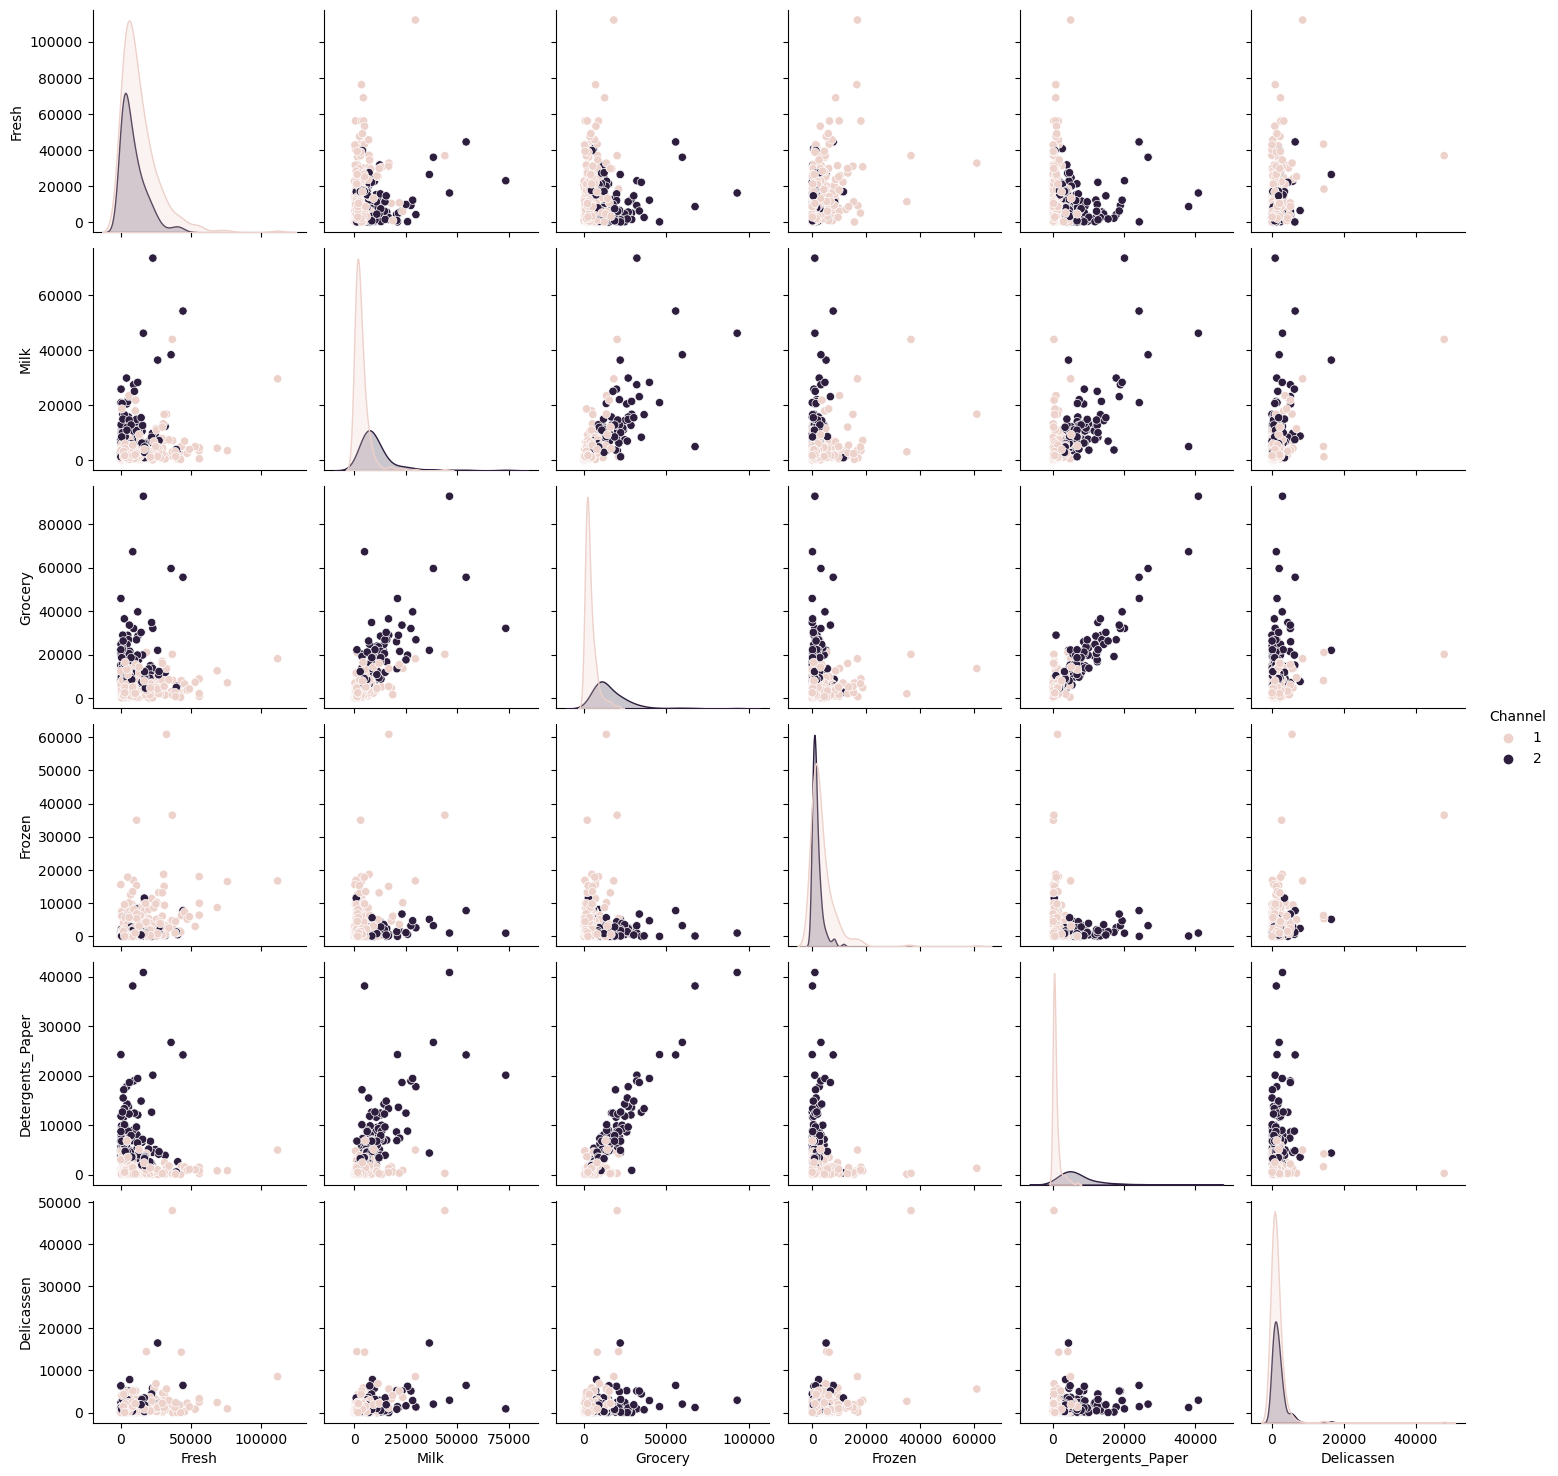

In [241]:
sns.pairplot(data=df[columns_2], hue='Channel')

#### C2.1) Logisztikus regresszió alkalmazása (1)

Miután kiszámoltam itt is a theta0, theta1, theta2 értékét, az ábrázoláshoz szükséges kiszámolni az x2-t is. Ezzel ábrázolható a döntési határ, ami elválasztja egymástól az egyes osztályokat.

In [242]:
x = df[['Frozen','Detergents_Paper']].to_numpy()
y = df['Channel'].to_numpy()

In [243]:
reg3 = LogisticRegression()
reg3.fit(x,y)

LogisticRegression()

In [244]:
theta0 = reg3.intercept_
theta0

array([-3.16798017])

In [245]:
theta1 = reg3.coef_[0,0]
theta1

-0.00011477663350446167

In [246]:
theta2 = reg3.coef_[0,1]
theta2

0.0010898143431638866

<Axes: xlabel='Frozen', ylabel='Detergents_Paper'>

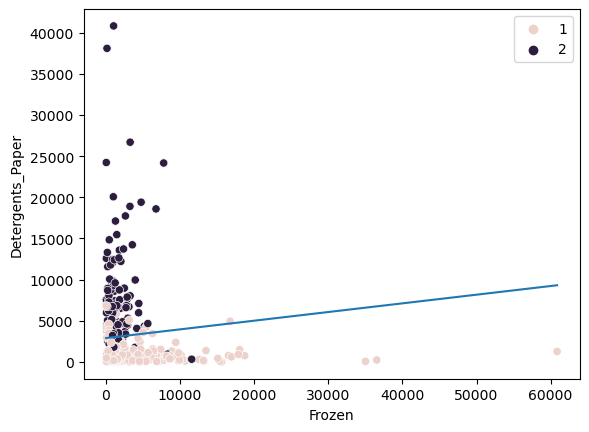

In [247]:
x2 = -(theta0+theta1*df['Frozen'])/theta2
sns.scatterplot(x=df['Frozen'],y=df['Detergents_Paper'],hue=df['Channel'])
sns.lineplot(x=df['Frozen'],y=x2)

In [248]:
reg3.predict([[10000,1000],[4000,10000]])

array([1, 2], dtype=int64)

#### C2.2) Logisztikus regresszió alkalmazása (2)

A következő logisztikus regressziós modellben a Frozen változót a Grocery-re cseréltem.

In [249]:
x = df[['Grocery','Detergents_Paper']].to_numpy()
y = df['Channel'].to_numpy()

In [250]:
reg4 = LogisticRegression()
reg4.fit(x,y)

LogisticRegression()

In [251]:
theta0 = reg4.intercept_
theta1 = reg4.coef_[0,0]
theta2 = reg4.coef_[0,1]

<Axes: xlabel='Grocery', ylabel='Detergents_Paper'>

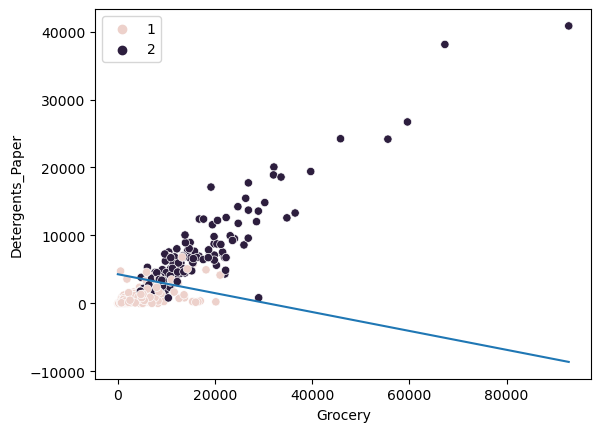

In [252]:
x2 = -(theta0+theta1*df['Grocery'])/theta2
sns.scatterplot(x=df['Grocery'],y=df['Detergents_Paper'],hue=df['Channel'])
sns.lineplot(x=df['Grocery'],y=x2)

In [ ]:
reg4.predict([[10000,10000]])

## D) Osztályozás, visszatartó gépi tanulás

#### D1) Attribútumok kiválasztása, osztályozási feladat megfogalmazása

Az osztályozás egy gépi tanulási feladat, amely során az algoritmusok arra törekszenek, hogy egy adott bemeneti adathalmaz alapján kategorikus vagy bináris kimenetet jósoljanak előre. Az osztályozási feladatom során a célom, hogy az ügyfél költései alapján a kereskedelmi szektor (Channel) kategóriái előrejelezhetők legyenek.

#### D2) Tanuló és teszthalmazra történő felbontás

Az X változó tartalmazza a bemeneti adatokat, az ügyfelek költését az egyes kategóriákban. Az y változó pedig a célváltozó, amelyet osztálycímkének választottunk ki. A train_test_split() segítségével tanuló és teszthalmazra bontottuk fel a bemeneti adatok és a célváltozó értékeit tartalmazó adattáblát is. A tanuló halmazba került az adatok 70%-a, a maradék pedig a teszthalmazba. Mivel a HoReCa és a kiskereskedelmi szektor között az adatok nem egyenletesen vannak eloszta, ezért szükséges a stratify=y paraméter. Ez azt biztosítja, hogy a tanuló és a teszt halmazokban is megmaradjon az eredeti eloszlás.

In [253]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [254]:
X = df.loc[:,"Fresh":"Delicassen"]
y = df["Channel"]

In [255]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y, random_state=1)

#### D3) Előfeldolgozás

Az előfeldolgozás során StandardScaler-t alkalmazva normalizálni kell a bemeneti adatokat, a modellünk pontossága érdekében. Ez a folyamat az egyes jellemzők eloszlását úgy alakítja át, hogy az átlag nulla és a szórás egy legyen, amivel azonos skálára is kerül a változók értéke.

In [256]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [257]:
X_train_normalized = scaler.transform(X_train)
df_train_normalized = X_train.copy()

In [258]:
df_train_normalized.loc[:,'Fresh':'Delicassen'] = X_train_normalized
df_train_normalized.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
379,-0.620204,-0.065138,0.274517,-0.590426,-0.417273,-0.429604
211,0.005190,3.356457,3.335520,0.304401,3.509966,0.452396
343,-0.802995,0.200766,1.938049,-0.332819,2.677722,-0.476146
50,-0.448107,-0.666229,-0.604099,0.134217,-0.460353,0.220342
366,-0.193021,-0.500482,-0.637108,-0.387798,-0.542078,-0.341764


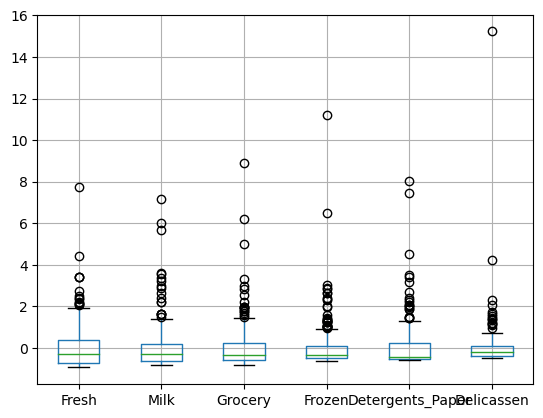

In [259]:
df_train_normalized.loc[:,'Fresh':'Delicassen'] = X_train_normalized
df_train_normalized.boxplot();

In [260]:
X_test_normalized = scaler.transform(X_test)

#### D4.1) Osztályozás logisztikus regresszióval

Az első osztályozást a logisztikus regresszió modelljével hajtjuk végre. Összehasonlíthatjuk a teszthalmazon előrejelzett és a tényleges kategóriákat is, de a modell pontosságát az accuracy_score() függvényének meghívásával még egyszerűbben megkapjuk. A mi modellünk esetében mind a tanuló, mind a teszthalmazon 90% környéki értékeket kaptunk, ami azt jelenti, hogy a modell jól teljesít a tanuló halmazon, és korábban nem látott adatokon is.

In [261]:
reg = LogisticRegression(max_iter=100000)
reg.fit(X_train_normalized,y_train)

LogisticRegression(max_iter=100000)

In [262]:
predicted = reg.predict(X_test_normalized)

In [263]:
list(zip(predicted,y_test))

[(1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 2),
 (1, 1),
 (1, 2),
 (2, 2),
 (2, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (2, 2),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 2),
 (2, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 2),
 (2, 2),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (1, 1),
 (1, 1),
 (2, 2),
 (2, 2),
 (1, 1),
 (1, 2),
 (2, 2),
 (1, 1),
 (1, 1),
 

In [264]:
test_acc = accuracy_score(y_test, predicted)
print("Test accuracy:",test_acc)

Test accuracy: 0.9015151515151515


In [265]:
train_acc = accuracy_score(y_train, reg.predict(X_train_normalized))
print("Train accuracy:",train_acc)

Train accuracy: 0.9058441558441559


In [266]:
conf = confusion_matrix(y_test, predicted)

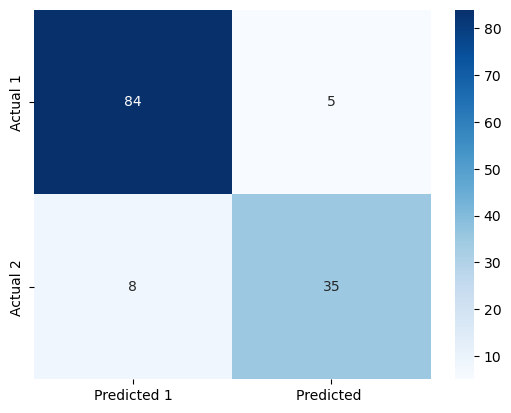

In [267]:
sns.heatmap(conf, annot=True,cmap='Blues', yticklabels=['Actual 1','Actual 2'], xticklabels=['Predicted 1','Predicted ']);

In [268]:
metrics.mean_squared_error(y_test, predicted)

0.09848484848484848

#### D4.2) Osztályozás SVM-el

In [ ]:
svm = SVC()
svm.fit(X_train_normalized,y_train)

In [ ]:
svm_pred = svm.predict(X_test_normalized)

In [ ]:
list(zip(svm_pred,y_test))

In [ ]:
test_acc = accuracy_score(y_test, svm_pred)
print("Test accuracy:",test_acc)

In [ ]:
train_acc = accuracy_score(y_train, svm.predict(X_train_normalized))
print("Train accuracy:",train_acc)

In [ ]:
conf = confusion_matrix(y_test, svm_pred)

In [ ]:
sns.heatmap(conf, annot=True,cmap='Blues', yticklabels=['Actual 1','Actual 2'], xticklabels=['Predicted 1','Predicted ']);

In [ ]:
metrics.mean_squared_error(y_test, svm_pred)